In [10]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
import random
def random_string(length,alphabet_list):
    rand_str = ''.join(random.choice(alphabet_list) for i in range(length))
    return rand_str

def perturb(seed,alphabet_list,p=0.5):
    seq=''
    for c in seed:
        if random.random() < p: c = random.choice(alphabet_list)
        seq += c
    return seq

def make_artificial_dataset(alphabet='ACGT', motives=None, motif_length=6, 
                            sequence_length=100, n_sequences=1000, n_motives=2, p=0.2,
                           random_state=1):
    random.seed(random_state)
    alphabet_list=[c for c in alphabet]
    
    if motives is None:
        motives=[]
        for i in range(n_motives):
            motives.append(random_string(motif_length,alphabet_list))
    else:
        motif_length = len(motives[0])
        n_motives = len(motives)
    
    sequence_length = sequence_length / len(motives)
    flanking_length = (sequence_length - motif_length ) / 2
    n_seq_per_motif = n_sequences

    counter=0
    seqs=[]
    for i in range(n_seq_per_motif):
        total_seq = ''
        total_binary_seq=''
        for j in range(n_motives):
            left_flanking = random_string(flanking_length,alphabet_list)
            right_flanking = random_string(flanking_length,alphabet_list)
            noisy_motif = perturb(motives[j],alphabet_list,p)
            seq = left_flanking + noisy_motif + right_flanking
            total_seq += seq
        seqs.append(('ID%d'%counter,total_seq))
        counter += 1
    binary_skeleton = '0' * flanking_length + '1' * motif_length + '0' * flanking_length
    binary_seq = binary_skeleton * n_motives
    return motives, seqs, binary_seq

In [12]:
from smod_wrapper import SMoDWrapper
from meme_wrapper import Meme
from sklearn.cluster import KMeans

In [26]:
def run_tool(motif_finder, scoring_criteria, pos_seqs, neg_seqs, 
             block_size, n_motives, min_motif_len, max_motif_len,
             complexity, min_score, min_freq, min_cluster_size,
             n_clusters, similarity_threshold, freq_threshold,p_value, 
             regex_th, sample_size, std_th):
    if motif_finder=='meme':
        with open('seqs.fa','w') as f_train:
            for seq in pos_seqs:
                f_train.write('>' + seq[0] + ' \n')
                f_train.write(seq[1] + '\n')

        tool =  Meme(alphabet='dna',
                     scoring_criteria = scoring_criteria,
                     minw=min_motif_len,
                     maxw=max_motif_len,
                     nmotifs=n_motives,
                     maxsize=1000000)
        tool.fit('seqs.fa')
    else:
        tool = SMoDWrapper(alphabet='dna',
                           scoring_criteria = scoring_criteria,
                           complexity = complexity,
                           n_clusters = n_clusters,
                           min_subarray_size = min_motif_len,
                           max_subarray_size = max_motif_len,
                           pos_block_size = block_size,
                           neg_block_size = block_size,
                           clusterer = KMeans(),
                           min_score = min_score,
                           min_freq = min_freq,
                           min_cluster_size = min_cluster_size,
                           similarity_th = similarity_threshold,
                           freq_th = freq_threshold,
                           p_value=p_value,
                           regex_th=regex_th,
                           sample_size=sample_size,
                           std_th=std_th)
        tool.fit(pos_seqs, neg_seqs)
    return tool

def score_seqs(seqs, n_motives, tool):
    scores = []
    for j in range(len(seqs)):
        seq_scr = []
        iters = tool.nmotifs
        for k in range(iters):
            scr=tool.score(motif_num=k+1, seq=seqs[j][1])
            seq_scr.append(scr)

        # taking average over all motives for a sequence
        if len(seq_scr) > 1:
            x = np.array(seq_scr[0])
            for l in range(1, iters):
                x = np.vstack((x, seq_scr[l]))
            seq_scr = list(np.mean(x, axis=0))
            scores.append(seq_scr)
        elif len(seq_scr) == 1:
            scores.append(np.array(seq_scr[0]))
        else:
            raise ValueError("no sequence score")
    return scores

In [51]:
import numpy as np
from sklearn.metrics import roc_auc_score
def evaluate(scoring_criteria='pwm', # ['pwm','hmm']
             motives=None,
             motif_length=6,
             n_motives=2,
             sequence_length=20,
             n_sequences=130,
             perturbation_prob=0.05,
             complexity=5,
             min_score=4,
             min_freq=0.25,
             min_cluster_size=5,
             n_clusters=15,
             min_subarray_size=5,
             max_subarray_size=10,
             similarity_threshold=.9,
             freq_threshold=None,
             p_value=0.05,
             regex_th=0.3,
             sample_size=200,
             std_th=None):

    motives, pos_seqs, binary_seq = make_artificial_dataset(alphabet='ACGT',
                                                            motives=motives,
                                                            sequence_length=sequence_length,
                                                            n_sequences=n_sequences,
                                                            motif_length=motif_length,
                                                            n_motives=n_motives,
                                                            p=perturbation_prob)
    
    from eden.modifier.seq import seq_to_seq, shuffle_modifier
    neg_seqs = seq_to_seq(pos_seqs, modifier=shuffle_modifier, times=1, order=2)
    neg_seqs = list(neg_seqs)

    block_size=n_sequences/8

    pos_size = len(pos_seqs)
    train_pos_seqs = pos_seqs[:pos_size/2]
    test_pos_seqs = pos_seqs[pos_size/2:]

    neg_size = len(neg_seqs)
    train_neg_seqs = neg_seqs[:neg_size/2]
    test_neg_seqs = neg_seqs[neg_size/2:]

    true_score = [float(int(i)) for i in binary_seq]

    tool_result = {'meme':[], 'smod':[]}
    for i in ['meme','smod']:
        tool = run_tool(motif_finder=i,
                        scoring_criteria = scoring_criteria,
                        pos_seqs=train_pos_seqs, 
                        neg_seqs=train_neg_seqs,
                        block_size=block_size,
                        n_motives=n_motives, 
                        complexity = complexity,
                        min_motif_len=min_subarray_size,
                        max_motif_len=max_subarray_size,
                        min_score=min_score,
                        min_freq=min_freq,
                        min_cluster_size=min_cluster_size,
                        n_clusters=n_clusters,
                        similarity_threshold=similarity_threshold,
                        freq_threshold=freq_threshold,
                        p_value=p_value,
                        regex_th=regex_th,
                        sample_size=sample_size,
                        std_th=std_th)
        
        scores = score_seqs(seqs=test_pos_seqs,
                            n_motives=n_motives,
                            tool=tool)

        mean_score = np.mean(scores, axis=0)
        roc_score = roc_auc_score(true_score, mean_score)
        tool_result[i].append(roc_score)
    return tool_result

In [52]:
% matplotlib inline
import pylab as plt 

def plot_results(data, title='Experiment', xlabel='param', ylabel='values'):
    data_x =  np.array([param for param, val_m, std_m, val_s, std_s in data])
    data_y_m =  np.array([val_m for param, val_m, std_m, val_s, std_s in data])
    data_d_m =  np.array([val_m for param, val_m, std_m, val_s, std_s in data])
    data_y_s =  np.array([val_s for param, val_m, std_m, val_s, std_s in data])
    data_d_s =  np.array([val_s for param, val_m, std_m, val_s, std_s in data])
    
    plt.figure(figsize=(16,3))
    line_m, = plt.plot(data_x, data_y_m, lw=4, ls='-', color='cornflowerblue')
    plt.fill_between(data_x, data_y_m - data_d_m, data_y_m + data_d_m, alpha=0.1, color="b")
    plt.plot(data_x, data_y_m, marker='o', color='w',linestyle='None',
                markersize=10, markeredgecolor='cornflowerblue', markeredgewidth=3.0)
    line_s, = plt.plot(data_x, data_y_s, lw=4, ls='-', color='red')
    plt.fill_between(data_x, data_y_s - data_d_s, data_y_s + data_d_s, alpha=0.1, color="r")
    plt.plot(data_x, data_y_s, marker='o', color='w',linestyle='None',
                markersize=10, markeredgecolor='red', markeredgewidth=3.0)
    
    d=10.0
    plt.xlim([min(data_x)-(max(data_x) - min(data_x))/d, max(data_x)+(max(data_x) - min(data_x))/d])
    plt.ylim([0.5, 1])
    plt.suptitle(title, fontsize=16)
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.legend((line_m, line_s), ('MEME', 'SMoD'), loc=0)
    plt.grid()
    plt.show()

In [53]:
n_rep = 10

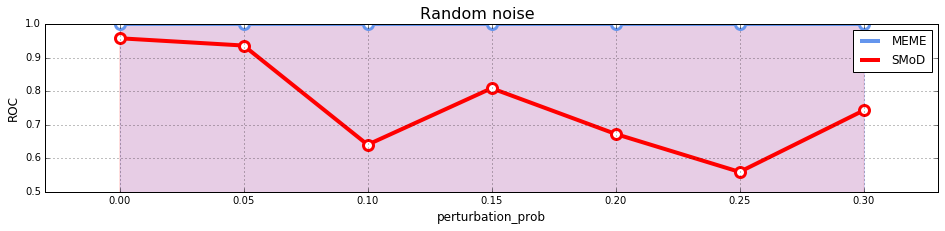

CPU times: user 9min 1s, sys: 28.4 s, total: 9min 30s
Wall time: 24min


In [38]:
%%time

def make_results(n_rep=n_rep):
    for param in [0.0, 0.05, 0.10, 0.15, 0.2, 0.25, 0.3]:
        results = {'meme':[], 'smod':[]}
        for rep in range(n_rep):
            tool_result = evaluate(scoring_criteria='pwm', # ['pwm','hmm']
                                   complexity=5,
                                   motif_length=10,
                                   n_motives=2,
                                   sequence_length=52,
                                   n_sequences=500,
                                   perturbation_prob=param,
                                   n_clusters=10,
                                   min_subarray_size=8,
                                   max_subarray_size=12,
                                   min_score=5,
                                   min_freq=0.65,
                                   min_cluster_size=2,
                                   similarity_threshold=1,
                                   freq_threshold=0.15,
                                   p_value=1,
                                   regex_th=0.5,
                                   sample_size=400,
                                   std_th = 1)            
            
            results['meme'].append(tool_result['meme'])
            results['smod'].append(tool_result['smod'])
        for tool in ['meme', 'smod']:
            avg = np.mean(results[tool])
            std = np.std(results[tool])
            results[tool] = (avg, std)
        yield param, results['meme'][0], results['meme'][1], results['smod'][0], results['smod'][1]


data = [(param, val_m, std_m, val_s, std_s) for param, val_m, std_m, val_s, std_s in make_results()]
plot_results(data, title='Random noise', xlabel='perturbation_prob', ylabel='ROC')

In [63]:
%%time

def make_results(n_rep=3):
    for param in [0.0, 0.05, 0.10, 0.15, 0.2, 0.25, 0.3]:
        results = {'meme':[], 'smod':[]}
        for rep in range(n_rep):
            tool_result = evaluate(scoring_criteria='pwm', # ['pwm','hmm']
                                   complexity=5,
                                   motif_length=10,
                                   n_motives=4,
                                   sequence_length=100,
                                   n_sequences=250,
                                   perturbation_prob=param,
                                   n_clusters=10,
                                   min_subarray_size=9,
                                   max_subarray_size=11,
                                   min_score=4,
                                   min_freq=0.5,
                                   min_cluster_size=2,
                                   similarity_threshold=0.1,
                                   freq_threshold=0.03,
                                   p_value=1,
                                   regex_th=0.5,
                                   sample_size=200,
                                   std_th = 1)
            
            results['meme'].append(tool_result['meme'])
            results['smod'].append(tool_result['smod'])
        for tool in ['meme', 'smod']:
            avg = np.mean(results[tool])
            std = np.std(results[tool])
            results[tool] = (avg, std)
        yield param, results['meme'][0], results['meme'][1], results['smod'][0], results['smod'][1]


data = [(param, val_m, std_m, val_s, std_s) for param, val_m, std_m, val_s, std_s in make_results()]
plot_results(data, title='Random noise', xlabel='perturbation_prob', ylabel='ROC')

AttributeError: 'NoneType' object has no attribute 'select_motives'

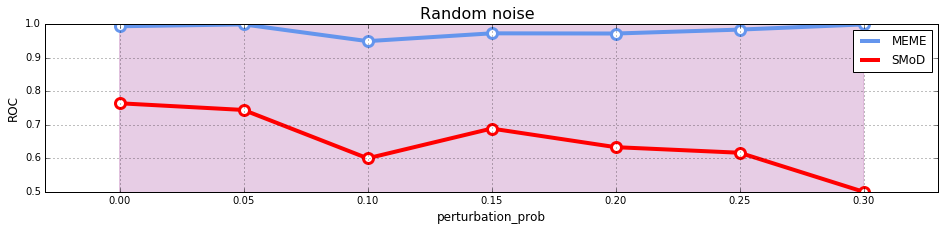

CPU times: user 1min 10s, sys: 4.3 s, total: 1min 14s
Wall time: 4min 11s


In [64]:
%%time

def make_results(n_rep=1):
    for param in [0.0, 0.05, 0.10, 0.15, 0.2, 0.25, 0.3]:
        results = {'meme':[], 'smod':[]}
        for rep in range(n_rep):
            tool_result = evaluate(scoring_criteria='pwm', # ['pwm','hmm']
                                   complexity=5,
                                   motif_length=10,
                                   n_motives=3,
                                   sequence_length=60,
                                   n_sequences=600,
                                   perturbation_prob=param,
                                   n_clusters=15,
                                   min_subarray_size=8,
                                   max_subarray_size=12,
                                   min_score=5,
                                   min_freq=0.65,
                                   min_cluster_size=2,
                                   similarity_threshold=1,
                                   freq_threshold=0.15,
                                   p_value=1,
                                   regex_th=0.5,
                                   sample_size=400,
                                   std_th = 1)
            
            results['meme'].append(tool_result['meme'])
            results['smod'].append(tool_result['smod'])
        for tool in ['meme', 'smod']:
            avg = np.mean(results[tool])
            std = np.std(results[tool])
            results[tool] = (avg, std)
        yield param, results['meme'][0], results['meme'][1], results['smod'][0], results['smod'][1]


data = [(param, val_m, std_m, val_s, std_s) for param, val_m, std_m, val_s, std_s in make_results()]
plot_results(data, title='Random noise', xlabel='perturbation_prob', ylabel='ROC')

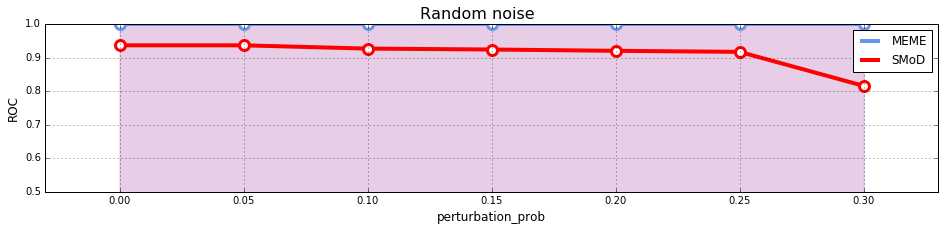

CPU times: user 2min 14s, sys: 9.04 s, total: 2min 23s
Wall time: 5min 6s


In [72]:
%%time

def make_results(n_rep=2):
    for param in [0.0, 0.05, 0.10, 0.15, 0.2, 0.25, 0.3]:
        results = {'meme':[], 'smod':[]}
        for rep in range(n_rep):
            tool_result = evaluate(scoring_criteria='pwm', # ['pwm','hmm']
                                   complexity=5,
                                   motif_length=10,
                                   n_motives=2,
                                   sequence_length=52,
                                   n_sequences=500,
                                   perturbation_prob=param,
                                   n_clusters=10,
                                   min_subarray_size=8,
                                   max_subarray_size=12,
                                   min_score=5,
                                   min_freq=0.65,
                                   min_cluster_size=2,
                                   similarity_threshold=1,
                                   freq_threshold=1,
                                   p_value=1,
                                   regex_th=0.5,
                                   sample_size=400,
                                   std_th = 1)
            
            results['meme'].append(tool_result['meme'])
            results['smod'].append(tool_result['smod'])
        for tool in ['meme', 'smod']:
            avg = np.mean(results[tool])
            std = np.std(results[tool])
            results[tool] = (avg, std)
        yield param, results['meme'][0], results['meme'][1], results['smod'][0], results['smod'][1]


data = [(param, val_m, std_m, val_s, std_s) for param, val_m, std_m, val_s, std_s in make_results()]
plot_results(data, title='Random noise', xlabel='perturbation_prob', ylabel='ROC')

In [84]:
%%time

def make_results(n_rep=1):
    for param in [0.0, 0.05, 0.10, 0.15, 0.2, 0.25, 0.3]:
        results = {'meme':[], 'smod':[]}
        for rep in range(n_rep):
            tool_result = evaluate(scoring_criteria='pwm', # ['pwm','hmm']
                                   complexity=5,
                                   motif_length=10,
                                   n_motives=2,
                                   sequence_length=52,
                                   n_sequences=500,
                                   perturbation_prob=param,
                                   n_clusters=10,
                                   min_subarray_size=8,
                                   max_subarray_size=12,
                                   min_score=5,
                                   min_freq=0.65,
                                   min_cluster_size=2,
                                   similarity_threshold=1,
                                   freq_threshold=1,
                                   p_value=1,
                                   regex_th=0.5,
                                   sample_size=400,
                                   std_th = 1)
            
            results['meme'].append(tool_result['meme'])
            results['smod'].append(tool_result['smod'])
        for tool in ['meme', 'smod']:
            avg = np.mean(results[tool])
            std = np.std(results[tool])
            results[tool] = (avg, std)
        yield param, results['meme'][0], results['meme'][1], results['smod'][0], results['smod'][1]


data = [(param, val_m, std_m, val_s, std_s) for param, val_m, std_m, val_s, std_s in make_results()]
plot_results(data, title='Random noise', xlabel='perturbation_prob', ylabel='ROC')

AttributeError: 'NoneType' object has no attribute 'select_motives'

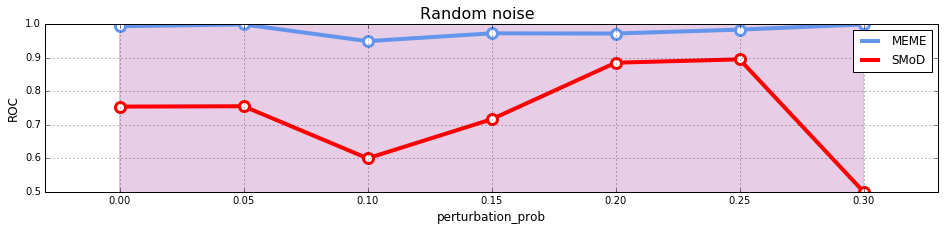

CPU times: user 1min 19s, sys: 4.85 s, total: 1min 23s
Wall time: 4min 20s


In [85]:
%%time

def make_results(n_rep=1):
    for param in [0.0, 0.05, 0.10, 0.15, 0.2, 0.25, 0.3]:
        results = {'meme':[], 'smod':[]}
        for rep in range(n_rep):
            tool_result = evaluate(scoring_criteria='pwm', # ['pwm','hmm']
                                   complexity=5,
                                   motif_length=10,
                                   n_motives=3,
                                   sequence_length=60,
                                   n_sequences=600,
                                   perturbation_prob=param,
                                   n_clusters=15,
                                   min_subarray_size=8,
                                   max_subarray_size=12,
                                   min_score=5,
                                   min_freq=0.65,
                                   min_cluster_size=2,
                                   similarity_threshold=1,
                                   freq_threshold=0.15,
                                   p_value=1,
                                   regex_th=0.5,
                                   sample_size=400,
                                   std_th = 1)
            
            results['meme'].append(tool_result['meme'])
            results['smod'].append(tool_result['smod'])
        for tool in ['meme', 'smod']:
            avg = np.mean(results[tool])
            std = np.std(results[tool])
            results[tool] = (avg, std)
        yield param, results['meme'][0], results['meme'][1], results['smod'][0], results['smod'][1]


data = [(param, val_m, std_m, val_s, std_s) for param, val_m, std_m, val_s, std_s in make_results()]
plot_results(data, title='Random noise', xlabel='perturbation_prob', ylabel='ROC')

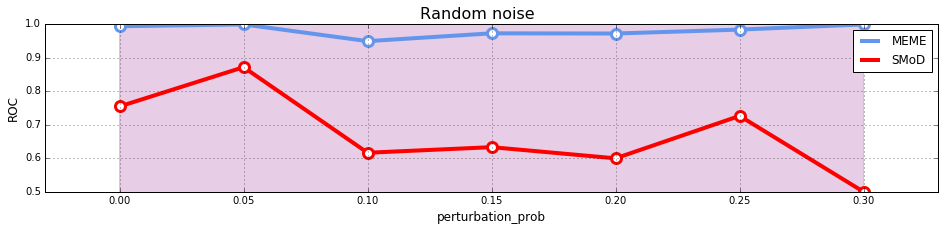

CPU times: user 1min 16s, sys: 4.77 s, total: 1min 20s
Wall time: 4min 19s


In [86]:
%%time

def make_results(n_rep=1):
    for param in [0.0, 0.05, 0.10, 0.15, 0.2, 0.25, 0.3]:
        results = {'meme':[], 'smod':[]}
        for rep in range(n_rep):
            tool_result = evaluate(scoring_criteria='pwm', # ['pwm','hmm']
                                   complexity=5,
                                   motif_length=10,
                                   n_motives=3,
                                   sequence_length=60,
                                   n_sequences=600,
                                   perturbation_prob=param,
                                   n_clusters=15,
                                   min_subarray_size=8,
                                   max_subarray_size=12,
                                   min_score=5,
                                   min_freq=0.65,
                                   min_cluster_size=2,
                                   similarity_threshold=1,
                                   freq_threshold=0.15,
                                   p_value=1,
                                   regex_th=0.5,
                                   sample_size=400,
                                   std_th = 1)
            
            results['meme'].append(tool_result['meme'])
            results['smod'].append(tool_result['smod'])
        for tool in ['meme', 'smod']:
            avg = np.mean(results[tool])
            std = np.std(results[tool])
            results[tool] = (avg, std)
        yield param, results['meme'][0], results['meme'][1], results['smod'][0], results['smod'][1]


data = [(param, val_m, std_m, val_s, std_s) for param, val_m, std_m, val_s, std_s in make_results()]
plot_results(data, title='Random noise', xlabel='perturbation_prob', ylabel='ROC')